In [33]:
import common_functions as cf
import numpy as np
import matplotlib.pyplot as plt

from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage import io, color, filters, morphology, measure, exposure
from skimage.transform import hough_line, hough_line_peaks
from scipy.ndimage import rotate
import cv2 

# Preprocessing


In [34]:


# Optimal Thresholding Function
def optimalThresholding(image):
    img = (cf.rgb2gray(image) if len(image.shape) > 2 else image).copy()
    img = (img / img.max() * 255).astype(np.uint8)

    counts = np.bincount(img.ravel(), minlength=256)
    total_pixels = img.size
    Tnew = np.dot(np.arange(256), counts) // total_pixels

    while True:
        below = np.arange(Tnew)
        above = np.arange(Tnew, 256)
        sum1, count1 = np.dot(counts[below], below), counts[below].sum() or 1
        sum2, count2 = np.dot(counts[above], above), counts[above].sum() or 1
        Tnext = round((sum1 / count1 + sum2 / count2) / 2)
        if Tnext == Tnew:
            break
        Tnew = Tnext

    img = np.where(img < Tnew, 0, 255).astype(np.uint8)
    return img

# Local Thresholding Function
def LocalThresholding(in_image, num_blocks=(2, 2)):
    img = in_image.copy()
    if len(img.shape) > 2:
        img = cf.rgb2gray(img)

    rows, cols = img.shape
    block_rows, block_cols = num_blocks
    row_step, col_step = rows // block_rows, cols // block_cols

    for i in range(block_rows):
        for j in range(block_cols):
            start_row, end_row = i * row_step, (i + 1) * row_step if i < block_rows - 1 else rows
            start_col, end_col = j * col_step, (j + 1) * col_step if j < block_cols - 1 else cols

            block = img[start_row:end_row, start_col:end_col]
            img[start_row:end_row, start_col:end_col] = optimalThresholding(block)

    return img

# Function to Detect the Star Line and Bounding Box
def detect_star_line(img):
    # Apply Canny edge detection
    edges = cf.canny(image=img, sigma=1, low_threshold=0.1, high_threshold=0.3)

    edges = (edges * 255).astype(np.uint8)  # Convert True to 255 and False to 0

    # Use Hough Transform to detect straight lines
    lines = cv2.HoughLines(edges.astype(np.uint8), 1, np.pi / 180, 100)
    bounding_box = None

    if lines is not None:
        # Use the first detected line
        rho, theta = lines[0][0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho

        # Calculate bounding box around the detected line
        card_height = 100  # Adjust as needed
        card_width = 200
        pt_top_left = (int(x0 - card_width / 2), int(y0 - card_height / 2))
        pt_bottom_right = (int(x0 + card_width / 2), int(y0 + card_height / 2))
        bounding_box = (pt_top_left, pt_bottom_right)

        # Draw the bounding box on the image
        cv2.rectangle(img, pt_top_left, pt_bottom_right, (0, 0, 0), 2)

    return img, bounding_box



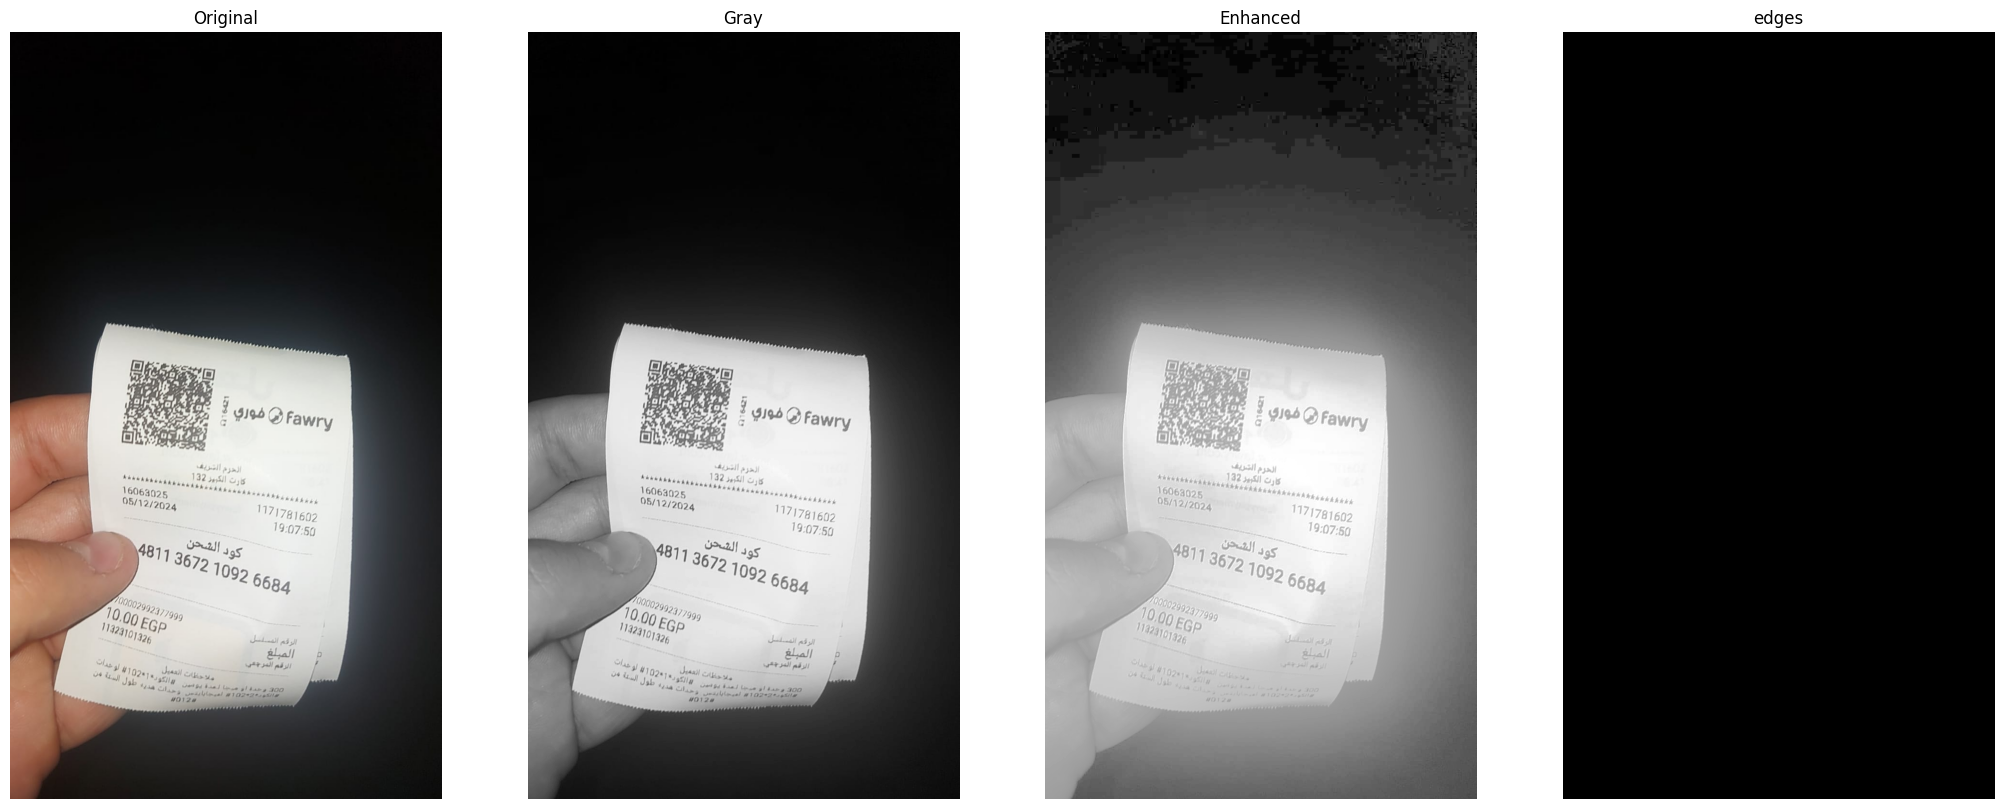

In [35]:
# Load and preprocess the image
image = io.imread('../imgs/24.jpg')
gray = color.rgb2gray(image)
enhanced = exposure.equalize_hist(gray)
binary = enhanced > filters.threshold_otsu(enhanced)

# Morphological operations
selem = morphology.disk(2)
cleaned = morphology.binary_opening(binary, selem)

edges =cf.canny(binary, low_threshold=50, high_threshold=150)  # Detect edges

contours = measure.find_contours(cleaned, level=0.5)

if contours:
    largest_contour = max(contours, key=lambda x: measure.approximate_polygon(x, tolerance=2).shape[0])
    min_row, min_col = np.min(largest_contour, axis=0)
    max_row, max_col = np.max(largest_contour, axis=0)
    receipt = image[int(min_row):int(max_row), int(min_col):int(max_col)]
cf.show_images([image, gray, enhanced, edges], ['Original', 'Gray', 'Enhanced','edges'])


Percentage of light reflections: 0.00%


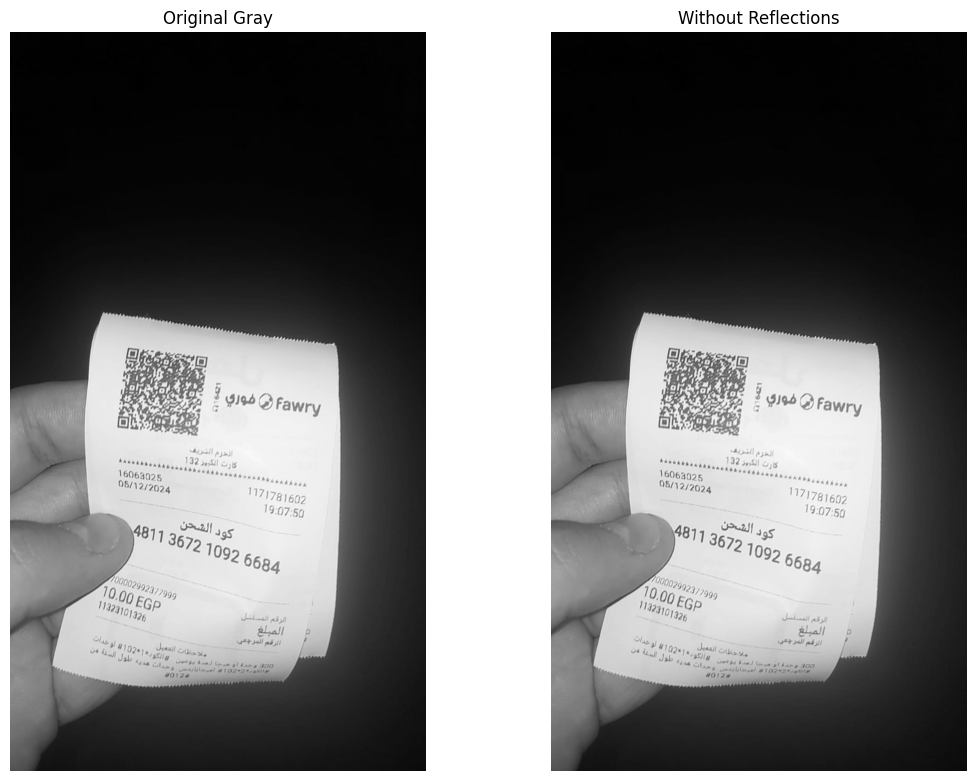

In [36]:
def remove_light_reflections(image, threshold=240):
    """
    Calculate the percentage of light reflections (high values) and remove them by setting the pixels to zero.
    
    Parameters:
    image (numpy.ndarray): Input grayscale image.
    threshold (int): Threshold value to consider a pixel as a light reflection. Default is 240.
    
    Returns:
    numpy.ndarray: Image with light reflections removed.
    float: Percentage of light reflections.
    """
    # Calculate the number of pixels above the threshold
    high_value_pixels = np.sum(image > threshold)
    
    # Calculate the total number of pixels
    total_pixels = image.size
    
    # Calculate the percentage of light reflections
    percentage_reflections = (high_value_pixels / total_pixels) * 100
    
    if percentage_reflections < 10:
        # Remove light reflections by setting the pixels to zero
        image[image > threshold] = 0

    # gray = (cf.rgb2gray(image) * 255).astype(np.uint8)
    # histogram, _ = np.histogram(gray, bins=256, range=(0, 1))
    # print(f"highlights: {np.sum(histogram[240:])}")
    # gray[gray > 240] = 0
    # enhanced = gray
    
    return image, percentage_reflections

# Example usage
image_with_reflections = gray.copy()
image_without_reflections, reflections_percentage = remove_light_reflections(image_with_reflections, threshold=200)
print(f"Percentage of light reflections: {reflections_percentage:.2f}%")
cf.show_images([gray, image_without_reflections], ['Original Gray', 'Without Reflections'])

Number of contours: 421


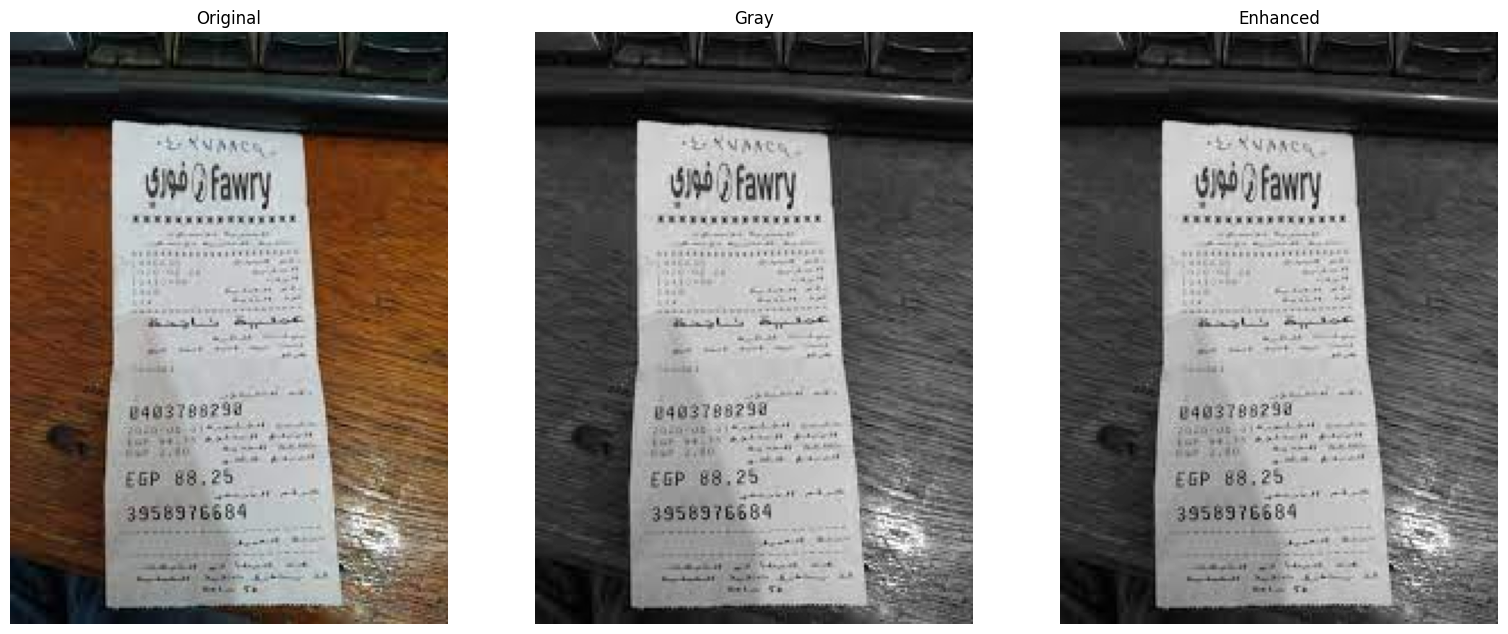

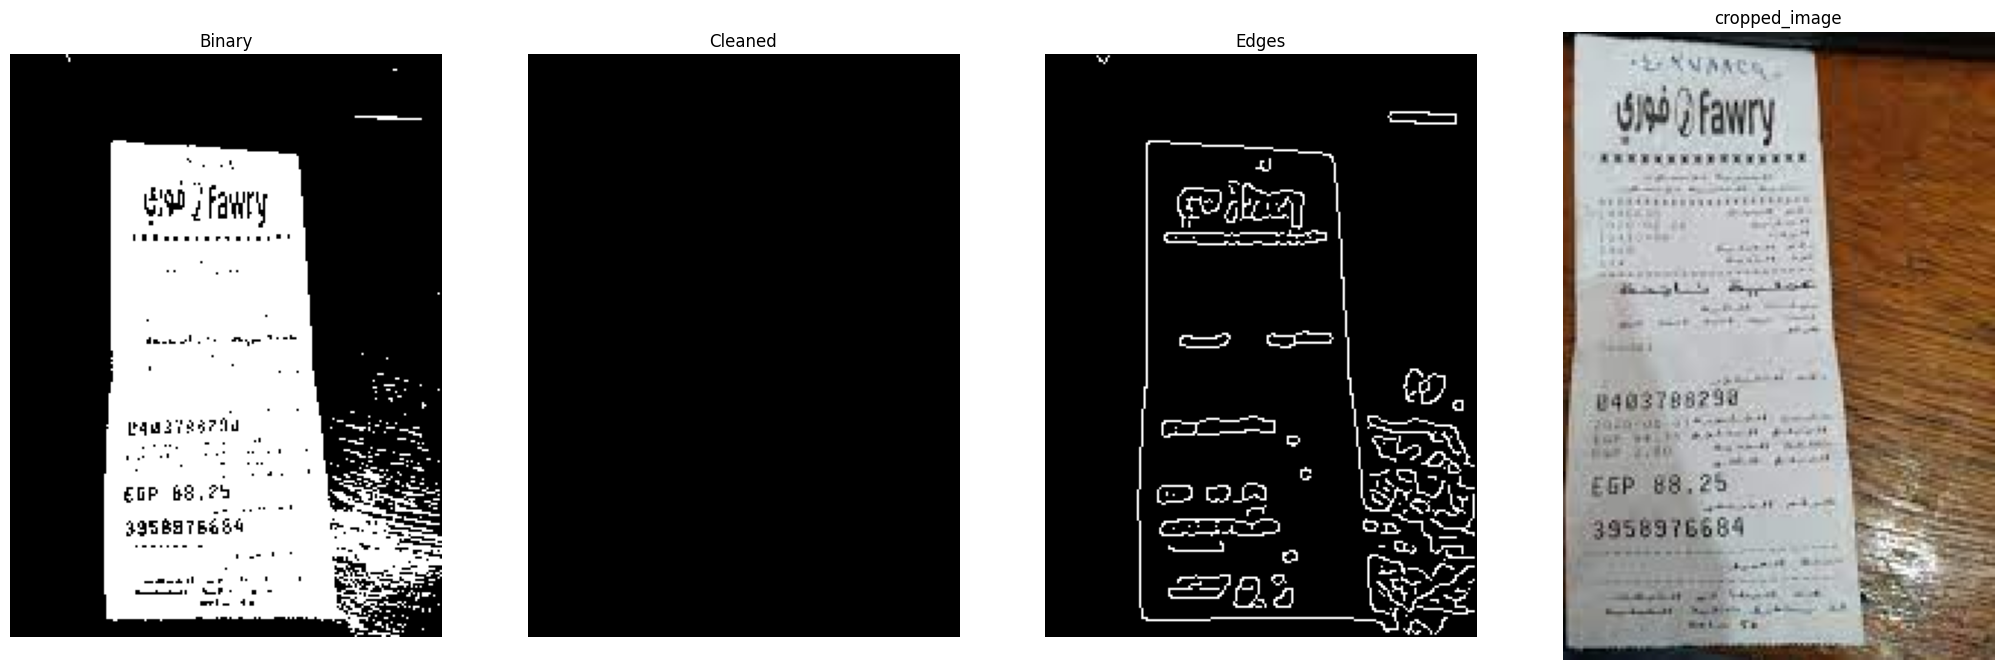

In [37]:
# working images : 1,2,3,4
# not working images : 5, 6 ,7 ,8
# Load the image
image = io.imread('../imgs/7.jpg')
# image = rotate(image, 180)

# Convert to grayscale
gray = cf.rgb2gray(image)

# Enhance contrast using histogram equalization : Histogram bta3et el lab mesh shghala leh ?
# enhanced = exposure.equalize_hist(gray)
enhanced = gray

# Apply Otsu's thresholding : will be implemented bas hagarabo 
thresh_val = filters.threshold_otsu(enhanced)
binary = enhanced > thresh_val  # Invert if needed: binary = enhanced <= thresh_val

# Edge detection
edges = cf.canny(binary, sigma=2)

cleaned = morphology.remove_small_holes(edges, area_threshold=500)
cleaned = morphology.remove_small_objects(cleaned, min_size=500)

# Find contours
contours = measure.find_contours(enhanced, level=0.5)
print(f"Number of contours: {len(contours)}")

# Select the largest contour (assumed to be the receipt)
largest_contour = max(contours, key=lambda x: measure.approximate_polygon(x, tolerance=2).shape[0])

# Get bounding box for the receipt
min_row, min_col = np.min(largest_contour, axis=0)
max_row, max_col = np.max(largest_contour, axis=0) 

# Calculate correceted bounding box
# Crop the receipt
receipt = image[int(min_row):int(max_row), int(min_col):int(max_col)]

cf.show_images([image, gray, enhanced], ['Original', 'Gray', 'Enhanced'])
cf.show_images([binary, cleaned, edges, receipt], ['Binary', 'Cleaned', 'Edges','cropped_image'])

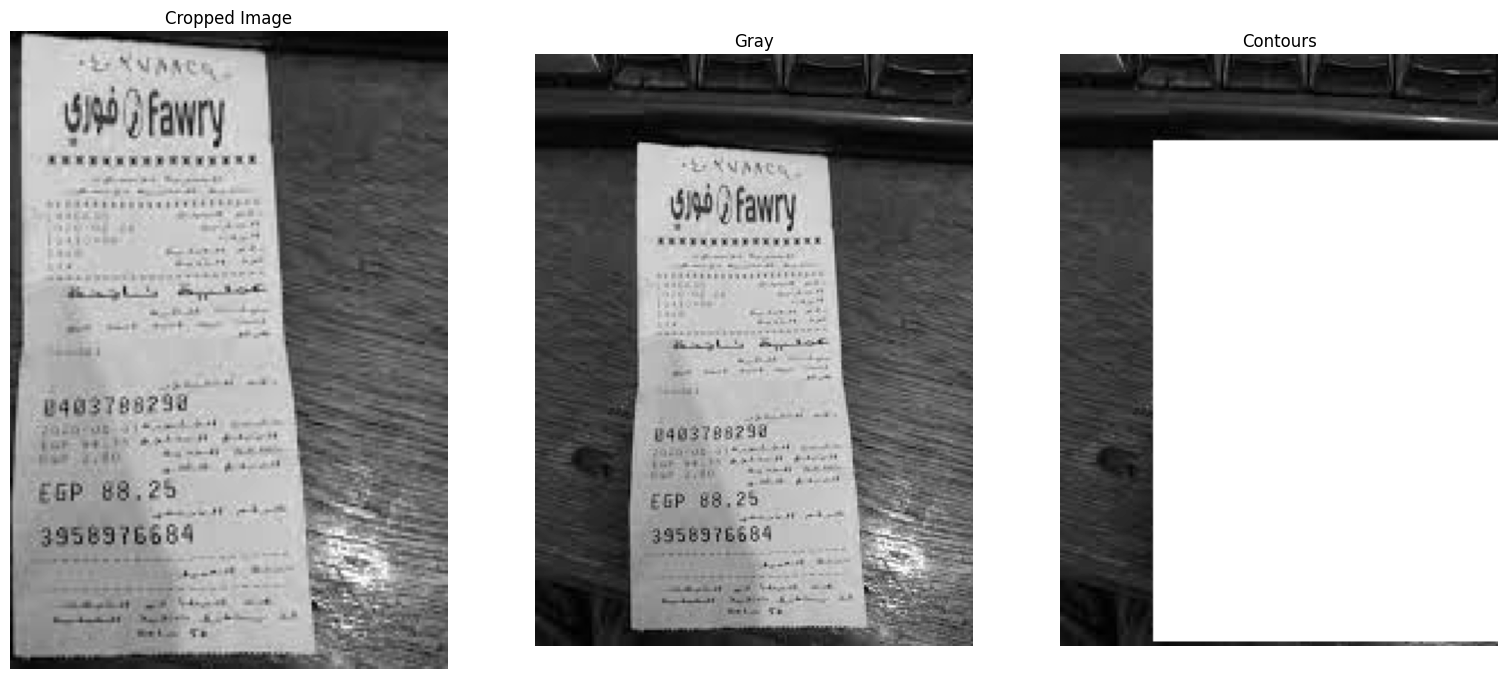

In [38]:
from skimage.draw import rectangle

def crop_max_contour(image: np.ndarray, threshold: float = 0.5) -> np.ndarray:
    # Find contours
    contours = measure.find_contours(image, level=0.5)
    width, height = image.shape
    
    # Find the largest contour
    max_object = None
    for contour in contours: 
        x_min = np.min(contour[:, 1])
        x_max = np.max(contour[:, 1])
        y_min = np.min(contour[:, 0])
        y_max = np.max(contour[:, 0])

        if (x_max - x_min) * (y_max - y_min) > threshold * width * height:
            max_object = (contour, x_min, x_max, y_min, y_max)

    if not max_object:
        return None, None
    
    x_min, x_max, y_min, y_max = max_object[1:]
    # Draw the bounding box
    countours_in_image = image.copy()
    rr, cc = rectangle(start=(int(y_min), int(x_min)), end=(int(y_max), int(x_max)), shape=image.shape)
    countours_in_image[rr, cc] = 1

    # Crop the image
    cropped_image = image[int(y_min):int(y_max), int(x_min):int(x_max)]
    return cropped_image, countours_in_image

cropped_receipt, tmp = crop_max_contour(gray, threshold=0.2)
if cropped_receipt is not None:
    cf.show_images([cropped_receipt, gray, tmp],["Cropped Image", "Gray", "Contours"])

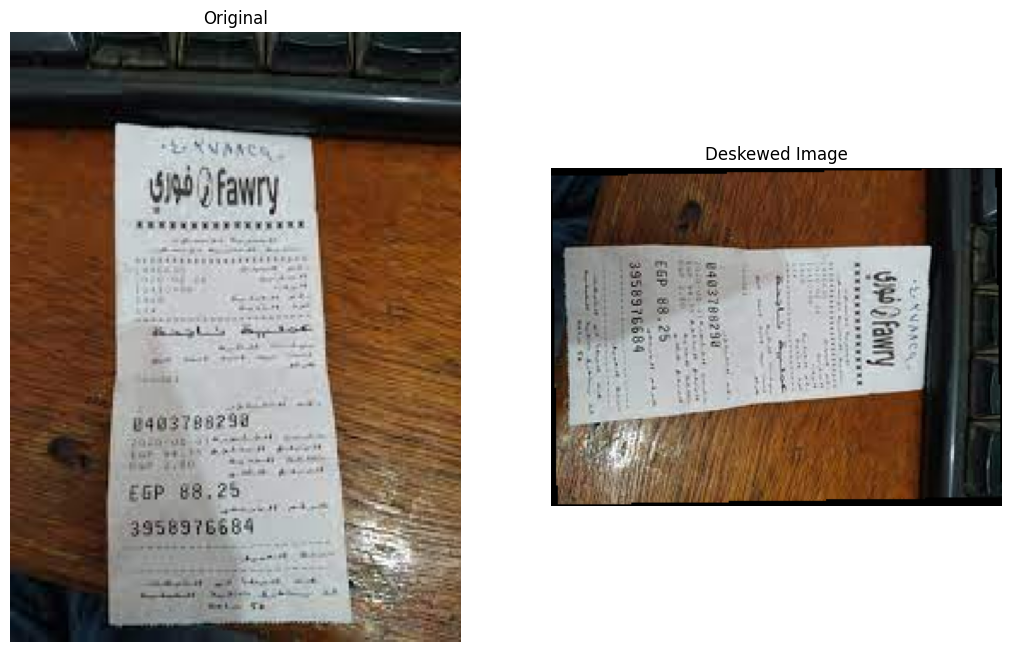

In [39]:
# Use the Hough transform to detect lines
h, theta, d = hough_line(edges)

# Calculate the skew angle
angles = []
for _, angle, _ in zip(*hough_line_peaks(h, theta, d)):
    angles.append(angle)

# Convert angles to degrees
angles = [np.degrees(a) for a in angles]
# median_angle = np.median(angles)
median_angle = np.max(angles)

# Rotate the image to correct skew
deskewed_image = rotate(image, -median_angle, reshape=True)
cf.show_images([image, deskewed_image], ['Original', 'Deskewed Image'])

In [40]:
from deskew import determine_skew

def deskew(deskewed_image):
    angle = determine_skew(deskewed_image)
    rotated = rotate(image, angle - 90) * 255
    return rotated.astype(np.uint8)

deskewed = deskew(image)
cf.show_images([image, deskewed], ['Original', 'Deskewed'])

ModuleNotFoundError: No module named 'deskew'